## Exercise 1.4 Hotdog -- no hotdog
This is the first poster hand-in exercise for the course. Please see the associated PDF for instructions.

In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [3]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='../hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [4]:
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 8
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)


Let's look at some images from our data 

In [5]:
# images, labels = next(iter(train_loader))
# plt.figure(figsize=(20,10))

# for i in range(21):
#     plt.subplot(5,7,i+1)
#     plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
#     plt.title(['hotdog', 'not hotdog'][labels[i].item()])
#     plt.axis('off')


Now create a model and train it!


In [6]:

init_type = init=nn.init.xavier_uniform_

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.convolutional1 = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                # nn.Dropout(0.25),
                nn.MaxPool2d(2,2),
        )

        self.convolutional2 = nn.Sequential(
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                # nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                # nn.Dropout(0.25),
                nn.MaxPool2d(2,2),
        )
        
        self.convolutional3 = nn.Sequential(
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                # nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                # nn.Dropout(0.25),
                nn.MaxPool2d(2,2),
        )

        self.fully_connected = nn.Sequential(
                nn.Linear(16*16*256, 2048),
                nn.ReLU(),
                nn.Linear(2048, 1024),
                nn.ReLU(),
                nn.Linear(1024, 256),
                nn.ReLU(),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Softmax(dim=1))
        
    def forward(self, x):
        x = self.convolutional1(x)
        x = self.convolutional2(x)
        x = self.convolutional3(x)
        
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        
        return x
    


In [7]:
model = Network()
model.to(device)
#Initialize the optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

In [8]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    def loss_fun(output, target):
        return F.nll_loss(torch.log(output), target)
    out_dict = {
              'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/256 [00:00<?, ?it/s]

Loss train: 0.707	 test: 0.652	 Accuracy train: 65.9%	 test: 67.7%


  0%|          | 0/256 [00:00<?, ?it/s]

Loss train: 0.569	 test: 0.536	 Accuracy train: 73.1%	 test: 74.1%


  0%|          | 0/256 [00:00<?, ?it/s]

Loss train: 0.526	 test: 0.579	 Accuracy train: 75.9%	 test: 71.8%


  0%|          | 0/256 [00:00<?, ?it/s]

Loss train: 0.483	 test: 0.566	 Accuracy train: 78.7%	 test: 76.4%


  0%|          | 0/256 [00:00<?, ?it/s]

Loss train: 0.545	 test: 0.520	 Accuracy train: 75.9%	 test: 75.4%


  0%|          | 0/256 [00:00<?, ?it/s]

Loss train: 0.455	 test: 0.542	 Accuracy train: 80.7%	 test: 74.7%


  0%|          | 0/256 [00:00<?, ?it/s]

Loss train: 0.437	 test: 0.511	 Accuracy train: 81.5%	 test: 76.3%


  0%|          | 0/256 [00:00<?, ?it/s]

Loss train: 0.417	 test: 0.582	 Accuracy train: 83.5%	 test: 71.5%


  0%|          | 0/256 [00:00<?, ?it/s]

Loss train: 0.394	 test: 0.523	 Accuracy train: 82.8%	 test: 74.3%


  0%|          | 0/256 [00:00<?, ?it/s]

Loss train: 0.374	 test: 0.544	 Accuracy train: 84.4%	 test: 76.0%


  0%|          | 0/256 [00:00<?, ?it/s]

Loss train: 0.343	 test: 0.588	 Accuracy train: 86.5%	 test: 75.9%


  0%|          | 0/256 [00:00<?, ?it/s]

Loss train: 0.323	 test: 0.647	 Accuracy train: 87.2%	 test: 76.3%


  0%|          | 0/256 [00:00<?, ?it/s]

Loss train: 0.258	 test: 0.709	 Accuracy train: 89.3%	 test: 73.7%


  0%|          | 0/256 [00:00<?, ?it/s]

Loss train: 0.231	 test: 0.652	 Accuracy train: 90.8%	 test: 76.3%


  0%|          | 0/256 [00:00<?, ?it/s]

Loss train: 0.207	 test: 0.676	 Accuracy train: 91.8%	 test: 76.7%


  0%|          | 0/256 [00:00<?, ?it/s]

Loss train: 0.157	 test: 0.662	 Accuracy train: 94.2%	 test: 76.2%


  0%|          | 0/256 [00:00<?, ?it/s]

Loss train: 0.146	 test: 0.916	 Accuracy train: 94.7%	 test: 74.9%


  0%|          | 0/256 [00:00<?, ?it/s]

Loss train: 0.107	 test: 1.149	 Accuracy train: 95.8%	 test: 73.4%


  0%|          | 0/256 [00:00<?, ?it/s]

Loss train: 0.156	 test: 0.925	 Accuracy train: 94.4%	 test: 75.8%


  0%|          | 0/256 [00:00<?, ?it/s]

Loss train: 0.091	 test: 1.173	 Accuracy train: 96.9%	 test: 71.5%


Text(0, 0.5, 'Accuracy')

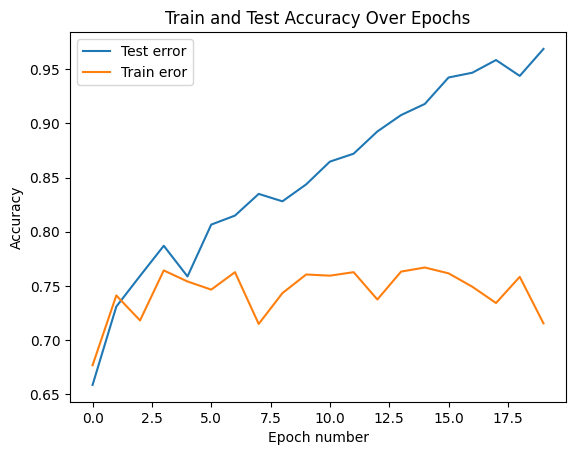

In [9]:
out_dict = train(model, optimizer, num_epochs=20)
plt.plot(out_dict['train_acc'], label='Train Accuracy')
plt.plot(out_dict['test_acc'], label='Test Accuracy')
plt.title('Train and Test Accuracy Over Epochs')
plt.legend(('Test error','Train eror'))
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')